In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/gi-disease-detection")

# Loading and Cleaning

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import os
import cv2
from imblearn.over_sampling import SMOTE
from google.cloud import storage
from google.oauth2 import service_account
import numpy as np

## Constants

In [4]:
SOURCE = "local"
BATCH_SIZE = 32
RAW_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/gi-disease-detection/raw_data"

GCLOUD_PROJECT_ID = "gi-disease-detection"
GCP_REGION = "europe-west4"

BUCKET_NAME = "gi-disease-raw-data"
GOOGLE_APPLICATION_CREDENTIALS = "/home/emilyma/code/emilyhma/gcp/gi-disease-detection-fa509a6759e5.json"

IMAGE_RESCALE_RATIO = 1. / 255
ROTATION_RANGE = 15
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1

IMAGE_TARGET_WIDTH = 100
IMAGE_TARGET_HEIGHT = 100

BOX_X1 = 0
BOX_X2 = 34
BOX_Y1 = 66
BOX_Y2 = 100

## Functions

In [5]:
def load_images(path, class_mode = "categorical", dataset_type = "train"):
    """
    Enter a path to load images from.
    
    class_mode should be "categorical" if we are calling this function on data with existing categories.
    class_mode should be None if we are calling this function on new data.
    
    dataset_type will be either "train," "val," or "test."
    """
    if dataset_type == "train":
        datagen = ImageDataGenerator(rescale = float(IMAGE_RESCALE_RATIO),
                                     rotation_range = int(ROTATION_RANGE),
                                     shear_range = float(SHEAR_RANGE),
                                     zoom_range = float(ZOOM_RANGE),
                                     horizontal_flip = True,
                                     width_shift_range = float(WIDTH_SHIFT_RANGE),
                                     height_shift_range = float(HEIGHT_SHIFT_RANGE))
    if dataset_type == "val" or dataset_type == "test":
        datagen = ImageDataGenerator(rescale = float(IMAGE_RESCALE_RATIO))

    images = datagen.flow_from_directory(path,
                                         target_size = (int(IMAGE_TARGET_WIDTH), int(IMAGE_TARGET_HEIGHT)),
                                         color_mode = "rgb",
                                         batch_size = int(BATCH_SIZE),
                                         class_mode = class_mode)

    return images

In [6]:
def convert_DI_to_numpy(dataset):
    """
    Converts DirectoryIterator dataset to numpy.array.
    Returns X and y values for each dataset.
    """
    dataset.reset()
    X = np.concatenate([dataset.next()[0] for i in range(dataset.__len__())])
    y = np.concatenate([dataset.next()[1] for i in range(dataset.__len__())])

    return X, y

In [107]:
def train_val_test_generator(source = SOURCE, class_mode = "categorical"):
    """
    If run on existing data, generates the train, validation, and test datasets,
    and the corresponding X and y for train, validation, and test. Set class_mode to "categorical".

    If run on new data, generates the numpy array for the uploaded image. Set class_mode to None.

    If number_of_classes = 2, apply SMOTE to avoid imbalanced classes (normal vs UC + polyps).

    If number_of_classes = 3, do not apply SMOTE since classes are already balanced (normal vs UC vs polyps).
    """
    if source == "local":
        train_directory = os.path.join(RAW_DATA_PATH, "train")
        val_directory = os.path.join(RAW_DATA_PATH, "val")
        test_directory = os.path.join(RAW_DATA_PATH, "test")

    #this doesn't work right now
    if source == "cloud":
        credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)
        client = storage.Client(project = GCLOUD_PROJECT_ID, credentials = credentials)
        bucket = client.get_bucket(BUCKET_NAME)

        train_directory = f"gs://{BUCKET_NAME}/train"
        val_directory = f"gs://{BUCKET_NAME}/val"
        test_directory = f"gs://{BUCKET_NAME}/test"

    if class_mode == "categorical":
        # X_train, y_train = convert_DI_to_numpy(load_images(train_directory, class_mode = class_mode, dataset_type = "train"))
        # X_val, y_val = convert_DI_to_numpy(load_images(val_directory, class_mode = class_mode, dataset_type = "val"))
        # X_test, y_test = convert_DI_to_numpy(load_images(test_directory, class_mode = class_mode, dataset_type = "test"))

        # return X_train, y_train, X_val, y_val, X_test, y_test

        train_dataset = load_images(train_directory, class_mode = class_mode, dataset_type = "train")
        val_dataset = load_images(val_directory, class_mode = class_mode, dataset_type = "val")
        test_dataset = load_images(test_directory, class_mode = class_mode, dataset_type = "test")

        return train_dataset, val_dataset, test_dataset

    #need to figure out how to submit the image
    #update "new_image_directory" accordingly
    if class_mode == None:
        numpy_image = convert_numpy_to_TFDataset(load_images("new_image_directory", class_mode = class_mode))

        return numpy_image

In [108]:
train_dataset, val_dataset, test_dataset = train_val_test_generator(source = SOURCE, class_mode = "categorical")

Found 2400 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [8]:
def preprocess_images(X: np.array):
    """
    Clean the images in X_train, X_val, and X_test.
    """
    def clean_image(image: np.array):
        """
        Input an image to add a rectangle to cover the green or black box on the resized and normalized image (-1 box).
        """
        # Identified ROI for specific corner box in resized and normalized image
        image_clean = cv2.rectangle(image, (int(BOX_X1), int(BOX_Y1)), (int(BOX_X2), int(BOX_Y2)), (-1, -1, -1), -1)

        return image_clean

    cleaned_X = []

    for i in range(X.shape[0]):
        cleaned_X.append(clean_image(X[i, :, :, :]))

    return cleaned_X

In [9]:
def convert_numpy_to_TFDataset(X, y):
    """
    Converts numpy.array back to TF format but this time a TF dataset.
    """
    dataset = Dataset.from_tensor_slices((X, y)).batch(int(BATCH_SIZE))

    return dataset

In [10]:
def pipeline(class_mode = "categorical"):
    """
    A pipeline of the entire cleaning process.
    If existing data, class_mode = "categorical".
    If new data, class_mode = None.
    """
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_generator(class_mode = class_mode)

    preprocessed_train = preprocess_images(X_train)
    preprocessed_val = preprocess_images(X_val)
    preprocessed_test = preprocess_images(X_test)

    train_dataset = convert_numpy_to_TFDataset(preprocessed_train, y_train)
    val_dataset = convert_numpy_to_TFDataset(preprocessed_val, y_val)
    test_dataset = convert_numpy_to_TFDataset(preprocessed_test, y_test)

    return train_dataset, val_dataset, test_dataset

## Loading `train_dataset`, `val_dataset`, and `test_dataset`

In [11]:
train_dataset, val_dataset, test_dataset = pipeline(class_mode = "categorical")

Found 2400 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [12]:
print(f"train: {train_dataset}")
print(f"val: {val_dataset}")
print(f"test: {test_dataset}")

train: <BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
val: <BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
test: <BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


# Basic CNN Model

In [110]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

In [ ]:
es = EarlyStopping(restore_best_weights = True)

In [ ]:
model = Sequential()

model.add(layers.Masking(mask_value = -1, input_shape = (100, 100, 3)))

model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = "relu"))
model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (3, 3)))

model.add(layers.Conv2D(64, kernel_size = (2, 2), activation = "relu"))
model.add(layers.Conv2D(64, kernel_size = (2, 2), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

model.add(layers.Conv2D(32, kernel_size = (2, 2), activation = "relu"))
model.add(layers.Conv2D(32, kernel_size = (2, 2), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# model.add(layers.Conv2D(16, kernel_size = (2, 2), activation = "relu"))
# model.add(layers.Conv2D(16, kernel_size = (2, 2), activation = "relu"))
# model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(rate = 0.2))

model.add(layers.Flatten())

# model.add(layers.Dense(500, activation = "relu"))
# model.add(layers.Dense(250, activation = "relu"))
# model.add(layers.Dense(125, activation = "relu"))
model.add(layers.Dense(1000, activation = "relu"))
model.add(layers.Dense(500, activation = "relu"))
model.add(layers.Dense(3, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        32832     
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        16448     
                                                        

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", metrics.Recall()])

In [ ]:
model.fit(train_dataset, validation_data = val_dataset, epochs = 10)

2023-03-14 12:48:29.352488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.


Epoch 1/10


2023-03-14 12:48:32.304711: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 157351936 exceeds 10% of free system memory.


75/75 [==============================] - 244s 3s/step - loss: 1.1003 - accuracy: 0.3192 - recall: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_recall: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 207s 3s/step - loss: 1.0988 - accuracy: 0.3158 - recall: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_recall: 0.0000e+00
Epoch 3/10
75/75 [==============================] - 210s 3s/step - loss: 1.0988 - accuracy: 0.3183 - recall: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_recall: 0.0000e+00
Epoch 4/10
75/75 [==============================] - 211s 3s/step - loss: 1.0988 - accuracy: 0.3154 - recall: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_recall: 0.0000e+00
Epoch 5/10
75/75 [==============================] - 208s 3s/step - loss: 1.0987 - accuracy: 0.3158 - recall: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_recall: 0.0000e+00
Epoch 6/10
75/75 [==============================] - 218s 3s/step - loss: 1.0

In [ ]:
model.evaluate(test_dataset)

19/19 [==============================] - 8s 411ms/step - loss: 1.0986 - accuracy: 0.3333 - recall: 0.0000e+00


[1.0986123085021973, 0.3333333432674408, 0.0]

## CNN Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Predicted Values

In [ ]:
predictions = model.predict(test_dataset)
predictions[:10]

19/19 [==============================] - 8s 392ms/step


array([[0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905],
       [0.33325854, 0.33328238, 0.33345905]], dtype=float32)

In [ ]:
predictions = pd.DataFrame(predictions)

In [ ]:
y_pred = np.array(predictions.idxmax(1))
y_pred[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Actual Values

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis = 0)
y_true[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y_true = pd.DataFrame(y_true)

In [ ]:
y_true = np.array(y_true.idxmax(1))
y_true[:10]

array([0, 0, 1, 0, 2, 0, 2, 0, 1, 2])

### CM

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")
classes = ["normal", "UC", "polyps"]

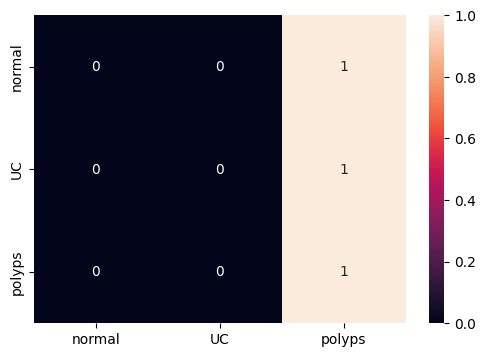

In [ ]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (6, 4))
cm_plot = sns.heatmap(df_cm, annot = True);

### Save CM

In [ ]:
cm_plot.figure.savefig("cm_normal_vs_UC_vs_polyps_baseline.png")

# EfficientNetB5 Model

In [15]:
from tensorflow.keras.applications import EfficientNetB5

In [118]:
base_enb5_model = EfficientNetB5(weights = "imagenet", include_top = False, input_shape = (100, 100, 3), pooling = "max")
base_enb5_model.trainable = True

In [124]:
es = EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss")

In [125]:
enb5_model = Sequential()
enb5_model.add(base_enb5_model)

enb5_model.add(layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001))

enb5_model.add(layers.Dense(1024,
                            kernel_regularizer = regularizers.l2(l = 0.016),
                            activity_regularizer = regularizers.l1(0.006),
                            bias_regularizer = regularizers.l1(0.006),
                            activation = "relu"))
enb5_model.add(layers.Dropout(rate = 0.3, seed = 123))

enb5_model.add(layers.Dense(128,
                            kernel_regularizer = regularizers.l2(l = 0.016),
                            activity_regularizer = regularizers.l1(0.006),
                            bias_regularizer = regularizers.l1(0.006),
                            activation = "relu"))
enb5_model.add(layers.Dropout(rate = 0.45, seed = 123))

enb5_model.add(layers.Dense(3, activation = "softmax"))

enb5_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", metrics.Precision(), metrics.Recall()])

In [126]:
enb5_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_89 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_90 (Dense)            (None, 128)               131200    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                     

In [ ]:
enb5_model.fit(train_dataset, validation_data = val_dataset, epochs = 30, callbacks = [es])

Epoch 1/30


In [123]:
enb5_model.evaluate(test_dataset)

19/19 [==============================] - 9s 427ms/step - loss: 2.1920 - accuracy: 0.3517 - precision_1: 0.3495 - recall_19: 0.3483


[2.1919686794281006,
 0.351666659116745,
 0.34949833154678345,
 0.34833332896232605]

## EfficientNetB5 Confusion Matrix

### Predicted Values

In [102]:
predictions = enb5_model.predict(test_dataset)
predictions[:10]

19/19 [==============================] - 5s 66ms/step


array([[0.00413943, 0.98314846, 0.01271219],
       [0.00537853, 0.9804813 , 0.01414014],
       [0.005584  , 0.98022264, 0.01419342],
       [0.00442293, 0.98267823, 0.01289888],
       [0.00374746, 0.9839279 , 0.01232471],
       [0.00503192, 0.98074305, 0.01422506],
       [0.00356389, 0.984576  , 0.01186018],
       [0.00384632, 0.9841345 , 0.01201922],
       [0.00431917, 0.98326266, 0.01241808],
       [0.0046131 , 0.98241454, 0.01297241]], dtype=float32)

In [103]:
predictions = pd.DataFrame(predictions)

In [104]:
y_pred = np.array(predictions.idxmax(1))
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Actual Values

In [52]:
y_true = np.concatenate([y for x, y in test_dataset], axis = 0)
y_true[:10]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [53]:
y_true = pd.DataFrame(y_true)

In [54]:
y_true = np.array(y_true.idxmax(1))
y_true[:10]

array([2, 0, 2, 0, 2, 2, 2, 1, 1, 0])

### CM

In [55]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")
classes = ["normal", "UC", "polyps"]

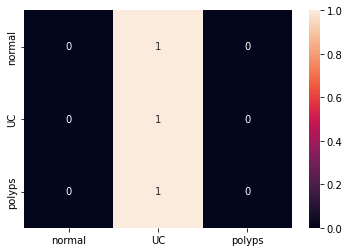

In [56]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (6, 4))
cm_plot = sns.heatmap(df_cm, annot = True);

### Save CM

In [57]:
cm_plot.figure.savefig("cm_normal_vs_UC_vs_polyps_enb5.png")